<b><u>BENSARD ET AL, 2019 NOTEBOOK</u></b>   
Paper: Loss of the Mitochondrial Pyruvate Carrier Promotes Tumor Initiation  
Paper Author: Claire L. Bensard, et. al.   
Code by Jordan A. Berg and Alex J. Bott   
Description: The following notebook contains the code required to replicate specified plots and supplements

<b><u>IMPORT DEPENDENCIES</u></b> 

In [1]:
import os
import pandas as pd 
import xpresstools as xp
from scipy import stats
%matplotlib inline

#Some data was also processed using Alt Analyze

#Set path to this directory for accessing and saving files
__path__  = os.getcwd() + '/'

<b><u>IMPORT HUMAN GSE8671 DATASET</u></b>   
The GEO-accessible data is not normalized. We therefore used Alt Analyze (http://www.altanalyze.org/) to RMA normalize probe signal.

In [2]:
#Get data
df_GSE8671 = xp.get_df(__path__ + 'data/GSE8671_rma_normalized.csv') #RMA normalized with Alt Analyze
info_GSE8671 = xp.get_info(__path__ + "data/sample_info_gse8671.csv")
df_GSE8671_c = xp.keep_labels(df_GSE8671, info_GSE8671, label_list=['Normal','Adenoma'])
df_GSE8671_clean = xp.clean_df(df_GSE8671_c)

#Collapse multi-mapping probes
df_GSE8671_collapsed = xp.probe_collapse(df_GSE8671_clean, __path__ + "data/GPL570.txt")
df_GSE8671_collapsed.to_csv(__path__ + "data/collapsed_GSE8671.csv",sep=',')

#Scale dataset
df_GSE8671_scaled, df_GSE8671_labeled = xp.prep_data(df_GSE8671_collapsed, info_GSE8671)

#sort by sample labels
info_GSE8671_sorted = info_GSE8671.copy()
info_GSE8671_sorted = info_GSE8671_sorted.loc[info_GSE8671_sorted[1].isin(['Adenoma', 'Normal'])]
info_GSE8671_sorted = info_GSE8671_sorted.sort_values([1], ascending=False)
info_GSE8671_sorted_list = info_GSE8671_sorted[0].tolist()
df_GSE8671_scaled_sorted = df_GSE8671_scaled[info_GSE8671_sorted_list]

#set palette
gse8671_colors = {'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

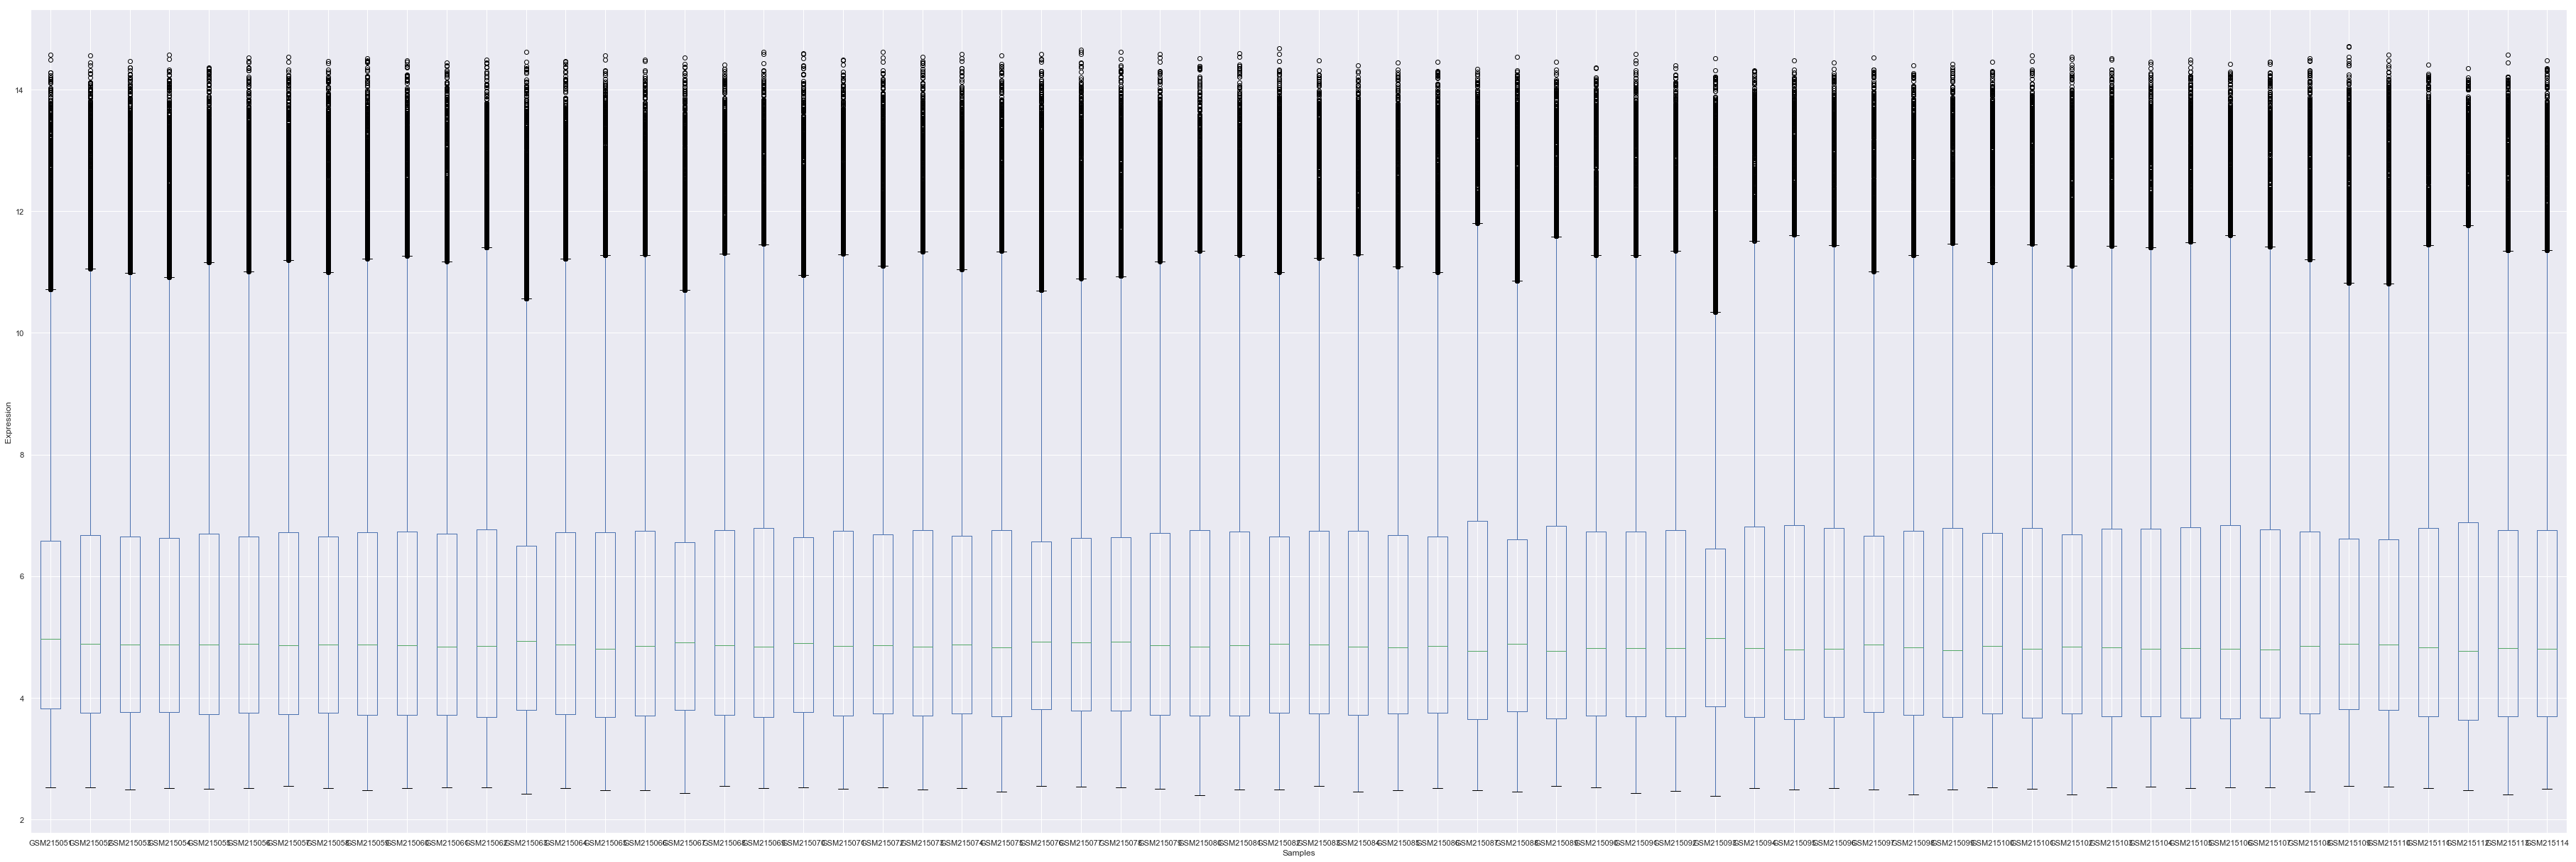

In [3]:
xp.check_samples(df_GSE8671_clean)

<b><u>IMPORT HUMAN GSE20916 DATASET</u></b> 

In [4]:
#Get data
df_GSE20916, info_GSE20916 = xp.get_geo('GSE20916')
info_GSE20916[1] = info_GSE20916[1].str.capitalize() #Make sample types look nice
info_GSE20916 = info_GSE20916.replace('Normal_colon', 'Normal')
df_GSE20916_c = xp.keep_labels(df_GSE20916, info_GSE20916, label_list=['Normal','Adenoma','Adenocarcinoma'])
df_GSE20916_clean = xp.clean_df(df_GSE20916_c)

#Collapse multi-mapping probes
df_GSE20916_collapsed = xp.probe_collapse(df_GSE20916_clean, __path__ + "data/GPL570.txt")
df_GSE20916_collapsed.to_csv(__path__ + "data/collapsed_GSE20916.txt",sep='\t')

#Scale sorted dataset
df_GSE20916_scaled, df_GSE20916_labeled = xp.prep_data(df_GSE20916_collapsed, info_GSE20916)

#sort by sample labels
info_GSE20916_sorted = info_GSE20916.copy()
info_GSE20916_sorted = info_GSE20916_sorted.loc[info_GSE20916_sorted[1].isin(['Adenoma', 'Adenocarcinoma','Normal'])]
info_GSE20916_sorted = info_GSE20916_sorted.sort_values([1], ascending=False)
info_GSE20916_sorted_list = info_GSE20916_sorted[0].tolist()
df_GSE20916_scaled_sorted = df_GSE20916_scaled[info_GSE20916_sorted_list]

#Drop Adenocarcinomas
df_GSE20916_collapsed_noac = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')

gse20916_colors = {'Adenocarcinoma': (0.5725490196078431, 0.5843137254901961, 0.5686274509803921),
        'Adenoma': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
        'Normal': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

04-Mar-2019 11:01:58 DEBUG utils - Directory ./ already exists. Skipping.
04-Mar-2019 11:01:58 INFO GEOparse - File already exist: using local version.
04-Mar-2019 11:01:58 INFO GEOparse - Parsing ./GSE20916_family.soft.gz: 
04-Mar-2019 11:01:58 DEBUG GEOparse - DATABASE: GeoMiame
04-Mar-2019 11:01:58 DEBUG GEOparse - SERIES: GSE20916
04-Mar-2019 11:01:58 DEBUG GEOparse - PLATFORM: GPL570
/anaconda3/lib/python3.6/site-packages/GEOparse/GEOparse.py:84: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523242
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523243
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523244
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523245
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523246
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523247
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM523248
04-Mar-2019 11:02:00 DEBUG GEOparse - SAMPLE: GSM5

04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523379
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523380
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523381
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523382
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523383
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523384
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523385
04-Mar-2019 11:02:08 DEBUG GEOparse - SAMPLE: GSM523386


Data processing summary:
{'Cell intensity files were generated using GCOS (Affymetrix). The probe set data was generated using R/BioConductor (version 2.8.1) packages affy (version 1.20.2), gcrma (version 2.14.1), and FLUSH.LVS.bundle (version 1.2.1, proportion=0.6). For data filtration, we selected the probe sets with signal intensity above the threshold limit in at least 5% of samples. The threshold was established at the 98th percentile of the expression levels from Y-chromosome–linked probe set signals detected detectable in female samples. In addition, the probe sets with signal FC higher than 1.5 (in relation to median) in less than 6 samples were removed.', 'Cell intensity files were generated using GCOS (Affymetrix). The probe set data was generated using R/BioConductor (version 2.8.1) packages affy (version 1.20.2), gcrma (version 2.14.1), and FLUSH.LVS.bundle (version 1.2.1, proportion=0.6). For data filtration, we selected the probe sets with signal intensity above the thres

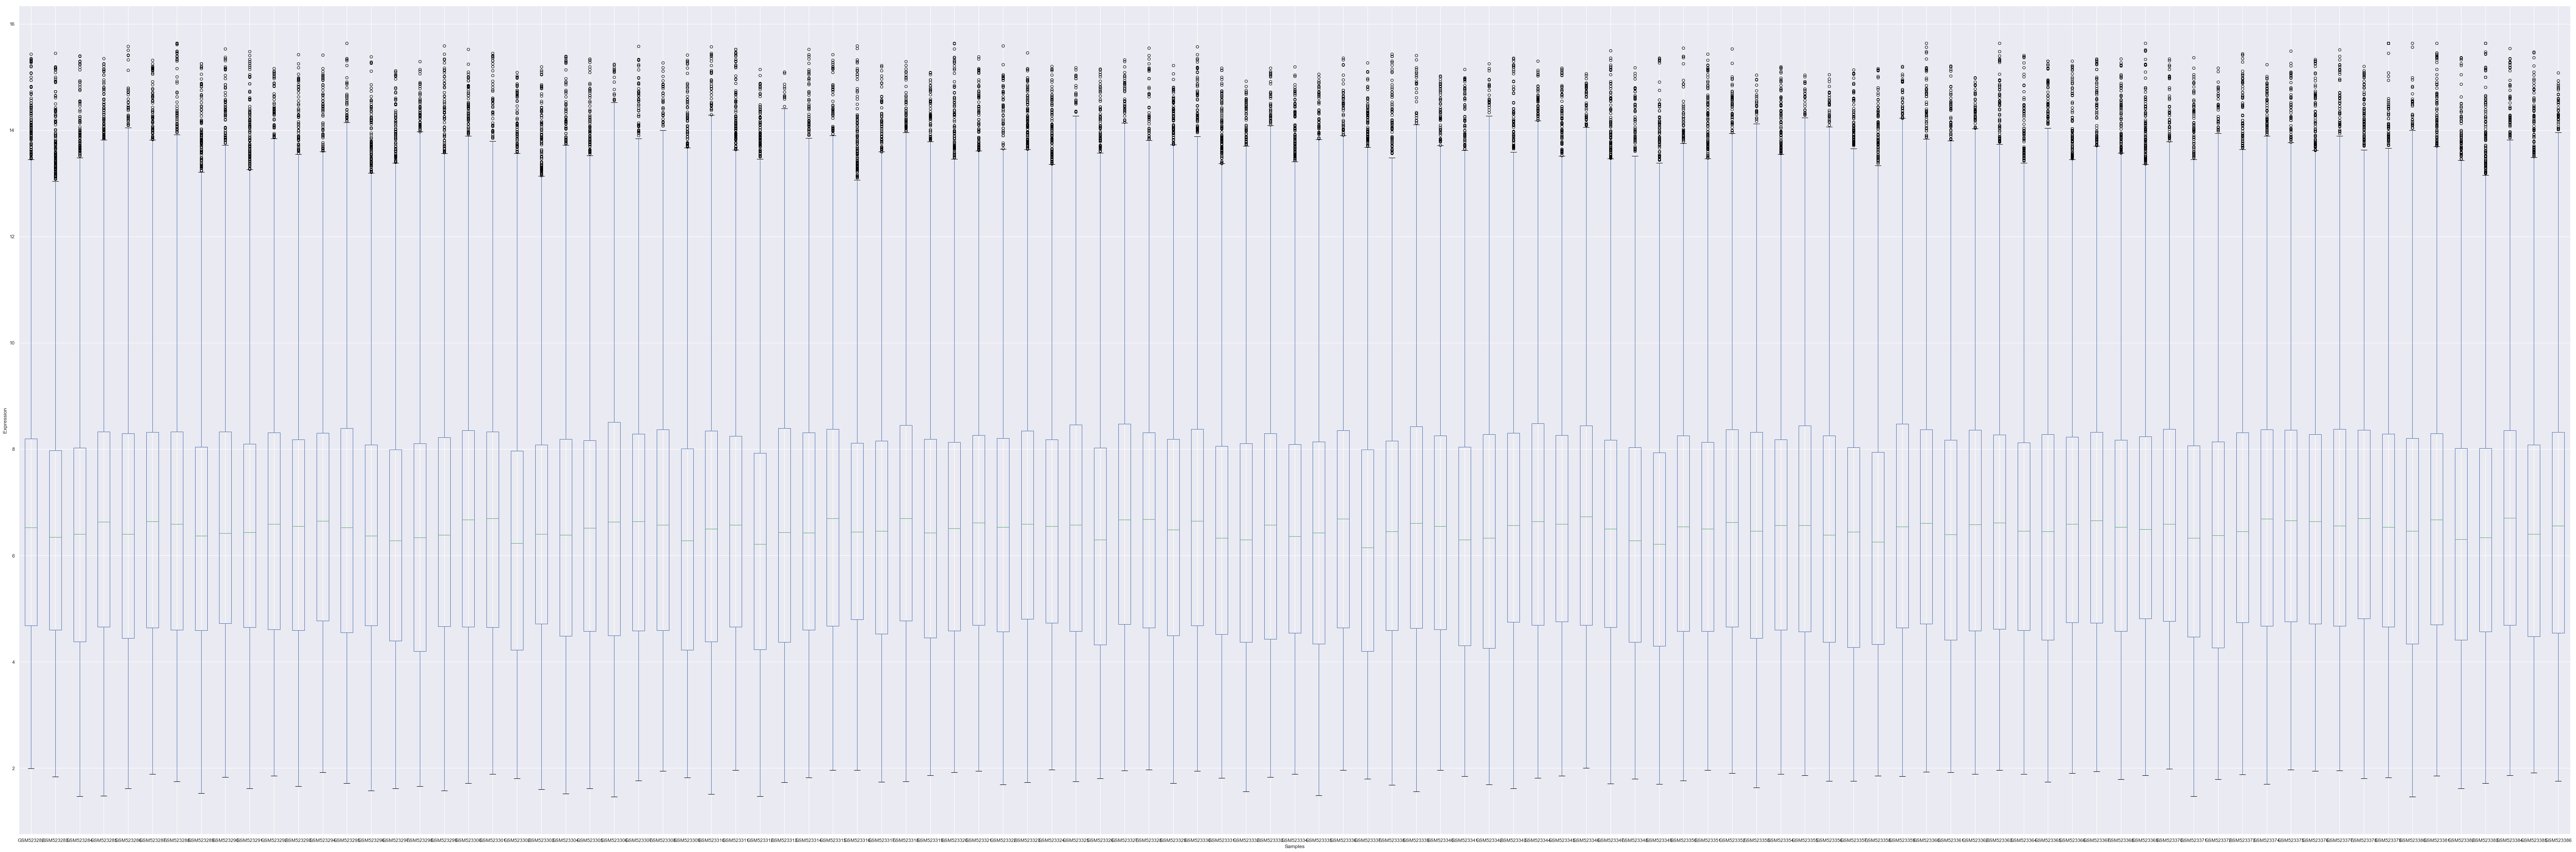

In [5]:
xp.check_samples(df_GSE20916_clean)

<b><u>IMPORT MOUSE APC DATASET</u></b> 

In [6]:
apc_df = pd.read_csv(__path__ + "data/custom_apc_normalized.csv", sep=",", index_col=0, low_memory=False)
apc_info = xp.get_info(__path__ + "data/apc_info.csv")
apc_clean = xp.clean_df(apc_df)
apc_scaled, apc_labeled = xp.prep_data(apc_clean, apc_info)

apc_colors = {'APC-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'APC-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

<b><u>IMPORT MOUSE AOMDSS DATASET</u></b> 

In [7]:
aomdss_df = pd.read_csv(__path__ + "data/custom_aomdss_normalized.csv", sep=",", index_col=0, low_memory=False)
aomdss_info = xp.get_info(__path__ + "data/aomdss_info.csv")
aomdss_clean = xp.clean_df(aomdss_df)
aomdss_scaled, aomdss_labeled = xp.prep_data(aomdss_clean, aomdss_info)

aomdss_colors = {'AOMDSS-KO': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         'AOMDSS-WT': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
         'Normal-KO': (0.8352941176470589, 0.3686274509803922, 0.0),
         'Normal-WT': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)}

<b><u>GET GENE SETS</u></b> 

In [8]:
with open(__path__ + "data/custom22.csv", 'r') as f:
    for line in f:
        custom22_mouse = line.split(",")
custom22_human = [x.upper() for x in custom22_mouse]

stem_genes = ['Ctnnb1','Notch1','Ascl2','Myc','Hopx','Sox9','Lgr5','Lef1','Mmp7','Axin2','Cd44','Ccnd1','Bmi1','Tert']
diff_genes = ['Fabp2','Atoh1','Muc2','Krt20','Chga','Vil1','MPC1','MPC2']

pyru = pd.read_csv('data/custom_pyruvate_list.csv',header=None)
pyru_list = pyru[0].tolist()

In [9]:
print(len(pyru_list))
print(df_GSE8671_labeled.reindex(pyru_list).dropna().shape)
print(df_GSE20916_labeled.reindex(pyru_list).dropna().shape)

80
(75, 64)
(60, 105)


In [10]:
GSE8671_pyru = df_GSE8671_labeled.reindex(pyru_list)
GSE8671_pyru.to_csv('./data/GSE8671_pyruvate_list.csv')

In [11]:
GSE20916_pyru = df_GSE20916_labeled.reindex(pyru_list)
GSE20916_pyru.to_csv('./data/GSE20916_pyruvate_list.csv')

<b><u>FIGURE 1</u></b> 

<Figure size 432x288 with 0 Axes>

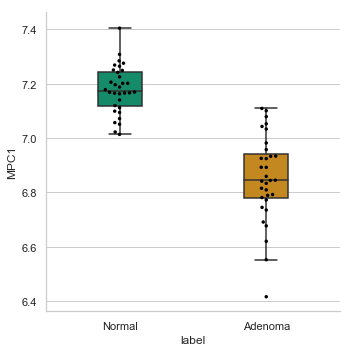

In [12]:
"""
LDH and MPC Relationship in Human Dataset GSE8671
"""
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC1',palette=gse8671_colors, 
                  order=['Normal','Adenoma'], grid=True, whitegrid=True,
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE8671.pdf')

<Figure size 432x288 with 0 Axes>

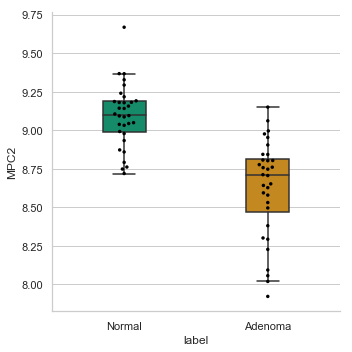

In [13]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='MPC2',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

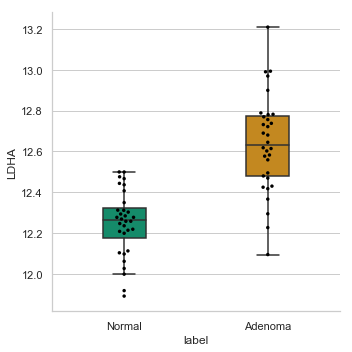

In [14]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHA',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

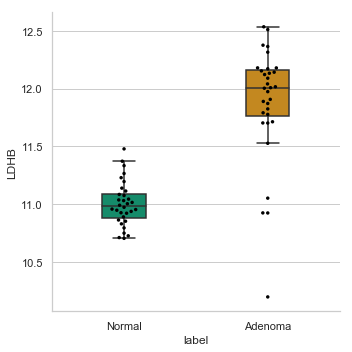

In [15]:
xp.gene_overview(df_GSE8671_labeled, info_GSE8671, gene_name='LDHB',palette=gse8671_colors, 
                  order=['Normal','Adenoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE8671.pdf', grid=True, whitegrid=True)

In [16]:
#Statistical tests
GSE8671_stats = df_GSE8671_labeled.loc[['MPC1','MPC2','LDHA','LDHB']]
GSE8671_norm = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Normal'][0].tolist()]
GSE8671_ad = GSE8671_stats[info_GSE8671.loc[info_GSE8671[1] == 'Adenoma'][0].tolist()]

print('GSE8671')

statistic, pvalue = stats.ttest_ind(xp.get_array(GSE8671_norm, 'MPC1'), xp.get_array(GSE8671_ad, 'MPC1'))
print('MPC1: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.ttest_ind(xp.get_array(GSE8671_norm, 'MPC2'), xp.get_array(GSE8671_ad, 'MPC2'))
print('MPC2: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.ttest_ind(xp.get_array(GSE8671_norm, 'LDHA'), xp.get_array(GSE8671_ad, 'LDHA'))
print('LDHA: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.ttest_ind(xp.get_array(GSE8671_norm, 'LDHB'), xp.get_array(GSE8671_ad, 'LDHB'))
print('LDHB: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

GSE8671
MPC1: statistic=10.167173312808213, p-value=7.832673691998662e-15
MPC2: statistic=7.042275616107644, p-value=1.8167807870916475e-09
LDHA: statistic=-7.6474345119041285, p-value=1.6196790872134913e-10
LDHB: statistic=-9.23814192878943, p-value=2.90854219689722e-13


<Figure size 432x288 with 0 Axes>

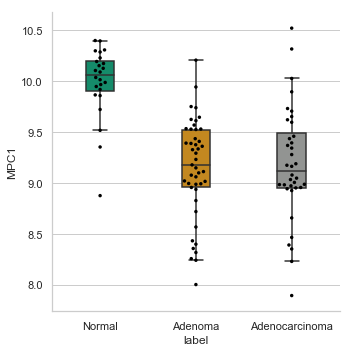

In [17]:
"""
LDH and MPC Relationship in Human Dataset GSE20916
"""
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC1',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC1_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

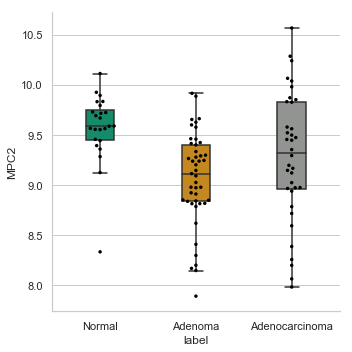

In [18]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='MPC2',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/MPC2_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

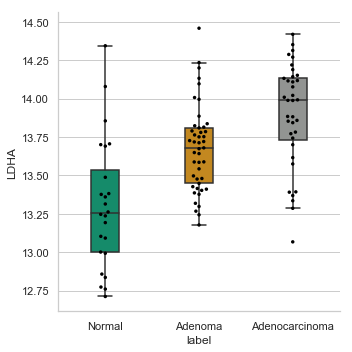

In [19]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHA',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHA_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

<Figure size 432x288 with 0 Axes>

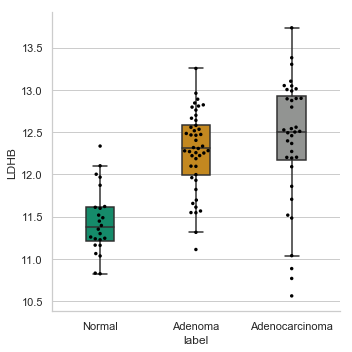

In [20]:
xp.gene_overview(df_GSE20916_labeled, info_GSE20916, gene_name='LDHB',palette=gse20916_colors, 
                  order=['Normal','Adenoma','Adenocarcinoma'],
                 save_fig=__path__ + 'plots/LDHB_boxswarm_GSE20916.pdf', grid=True, whitegrid=True)

In [21]:
#Statistical tests
GSE20916_stats = df_GSE20916_labeled.loc[['MPC1','MPC2','LDHA','LDHB']]
GSE20916_norm = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Normal'][0].tolist()]
GSE20916_ad = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Adenoma'][0].tolist()]
GSE20916_ac = GSE20916_stats[info_GSE20916.loc[info_GSE20916[1] == 'Adenocarcinoma'][0].tolist()]

print('GSE20916')

statistic, pvalue = stats.f_oneway(xp.get_array(GSE20916_norm, 'MPC1'), xp.get_array(GSE20916_ad, 'MPC1'), xp.get_array(GSE20916_ac, 'MPC1'))
print('MPC1: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.f_oneway(xp.get_array(GSE20916_norm, 'MPC2'), xp.get_array(GSE20916_ad, 'MPC2'), xp.get_array(GSE20916_ac, 'MPC2'))
print('MPC2: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.f_oneway(xp.get_array(GSE20916_norm, 'LDHA'), xp.get_array(GSE20916_ad, 'LDHA'), xp.get_array(GSE20916_ac, 'LDHA'))
print('LDHA: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

statistic, pvalue = stats.f_oneway(xp.get_array(GSE20916_norm, 'LDHB'), xp.get_array(GSE20916_ad, 'LDHB'), xp.get_array(GSE20916_ac, 'LDHB'))
print('LDHB: statistic=' + str(statistic) + ', p-value=' + str(pvalue))

GSE20916
MPC1: statistic=26.964814631493052, p-value=3.974182418383989e-10
MPC2: statistic=7.677818534895132, p-value=0.0007832619616353155
LDHA: statistic=21.894985484242113, p-value=1.2260230535988391e-08
LDHB: statistic=22.62903348487773, p-value=7.354868309053971e-09


<b><u>FIGURE 1 SUPPLEMENT</u></b> 

<Figure size 432x288 with 0 Axes>

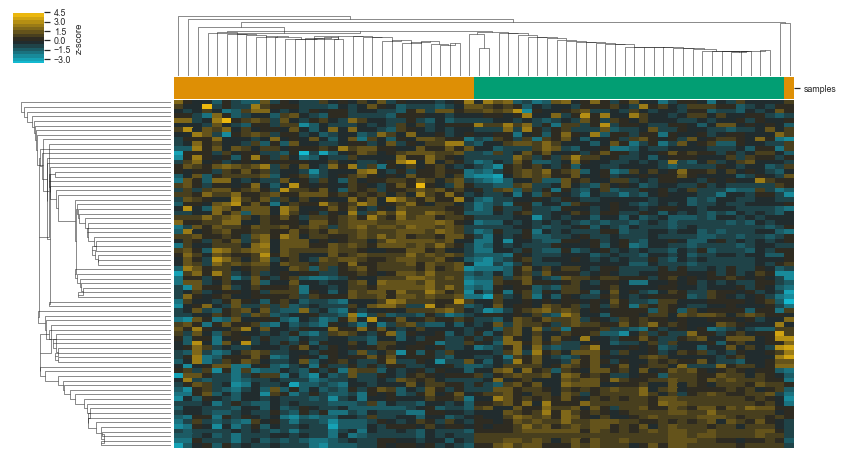

In [22]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671
"""
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

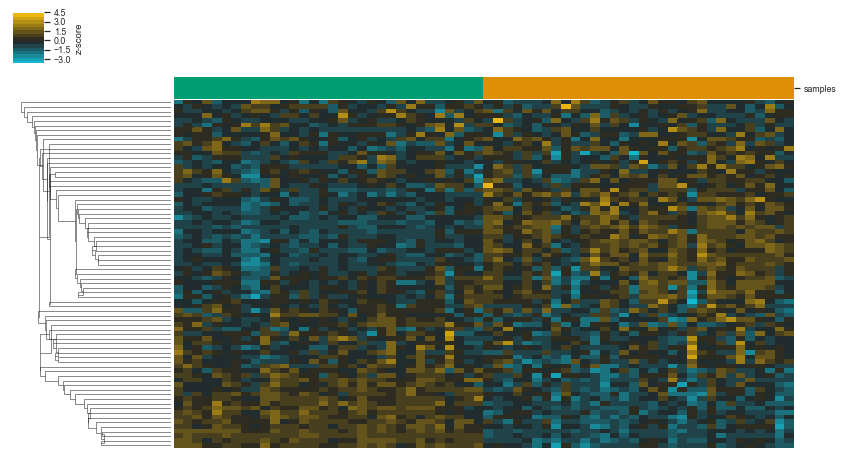

In [23]:
xp.heatmap(df_GSE8671_scaled_sorted, info_GSE8671, sample_palette=gse8671_colors, gene_list=pyru_list, 
            figsize=(14,8), save_fig=(__path__ + 'plots/GSE8671_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

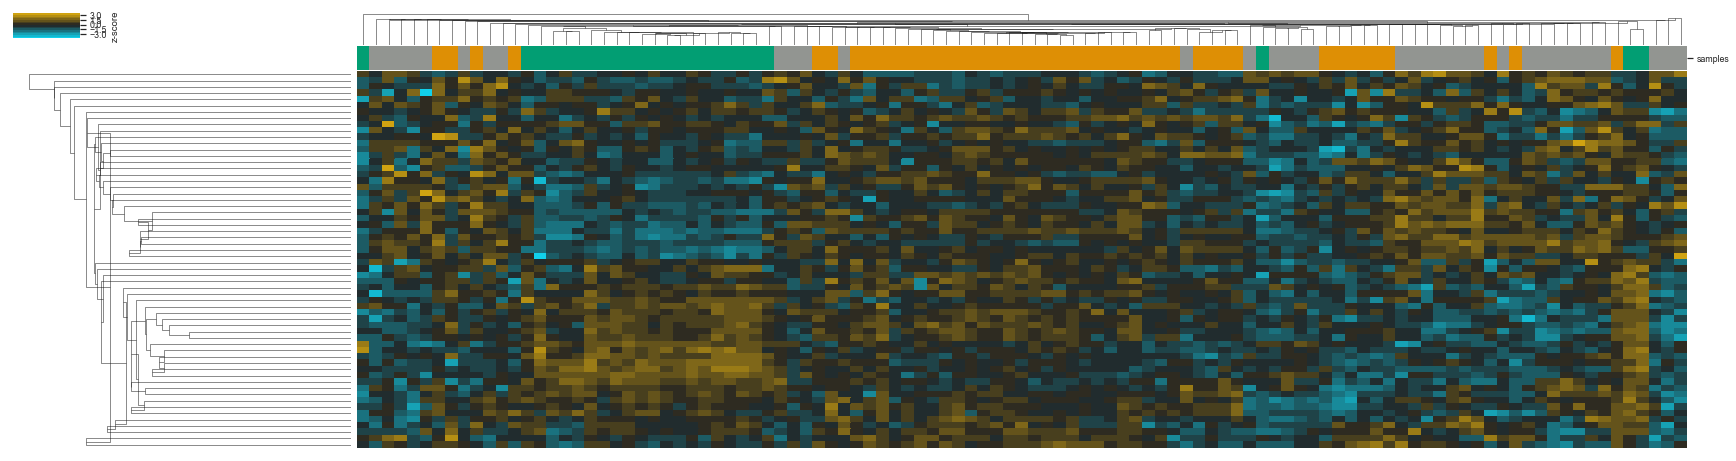

In [24]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916
"""
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap_colclustered.pdf'),
            row_cluster=True, col_cluster=True, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

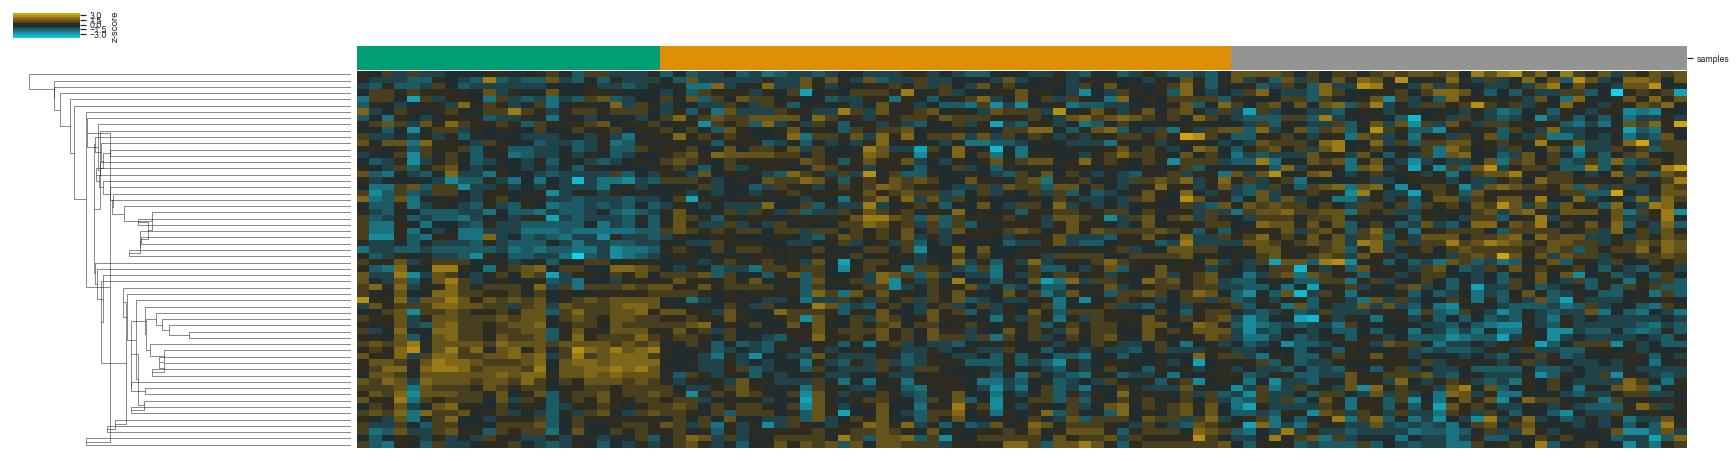

In [25]:
xp.heatmap(df_GSE20916_scaled_sorted, info_GSE20916, sample_palette=gse20916_colors, gene_list=pyru_list, 
            figsize=(30,8), save_fig=(__path__ + 'plots/GSE20916_customPyruvate_heatmap.pdf'),
            row_cluster=True, col_cluster=False, yticklabels=False, xticklabels=False,
            cbar_kws={'label': 'z-score'}, linewidths=0)

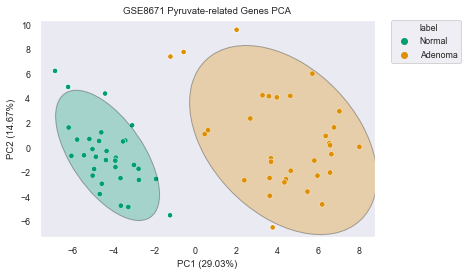

In [26]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE8671_pyru_list_PCA_scree.pdf',
       title='GSE8671 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_pyru_list_2CI_PCA.pdf')

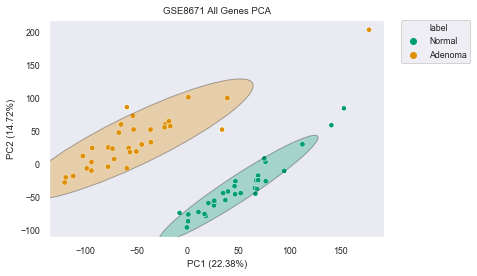

In [27]:
"""
Overall Gene Expression Changes in Human Dataset GSE8671 -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors,
       save_scree=__path__ + 'plots/GSE8671_all_genes_PCA_scree.pdf',
       title='GSE8671 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE8671_all_genes_2CI_PCA.pdf')

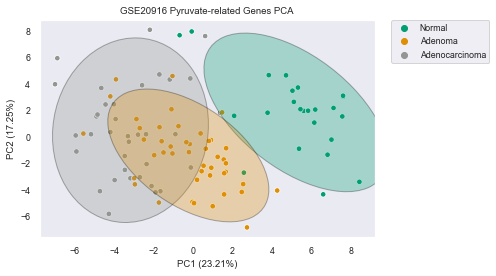

In [28]:
"""
Pyruvate-related Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
        gene_list=pyru_list,
       save_scree=__path__ + 'plots/GSE20916_pyru_list_PCA_scree.pdf',
       title='GSE20916 Pyruvate-related Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_pyru_list_2CI_PCA.pdf')

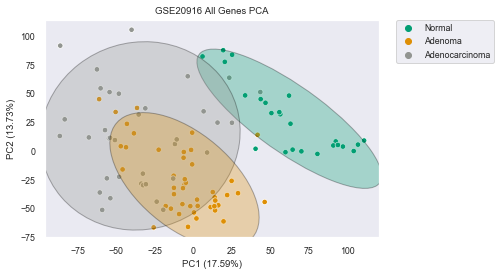

In [29]:
"""
Overall Gene Expression Changes in Human Dataset GSE20916 -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2],
       save_scree=__path__ + 'plots/GSE20916_all_genes_PCA_scree.pdf',
       title='GSE20916 All Genes PCA', 
        save_fig=__path__ + 'plots/GSE20916_all_genes_2CI_PCA.pdf')

<b><u>FIGURE 4</u></b> 

<Figure size 432x288 with 0 Axes>

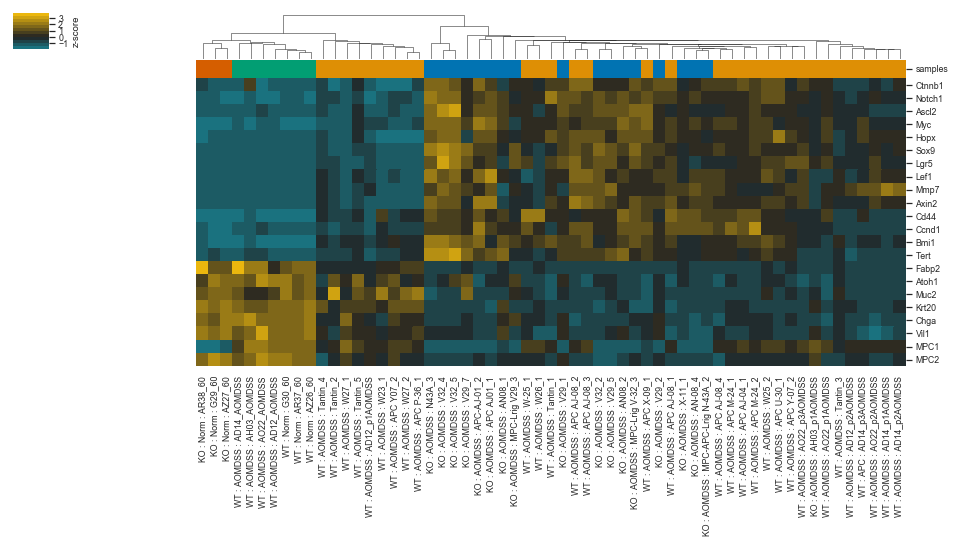

In [30]:
"""
Mouse AOMDSS Heatmap Custom22 Probes
"""
xp.heatmap(aomdss_scaled, aomdss_info, sample_palette=aomdss_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/AOMDSS_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

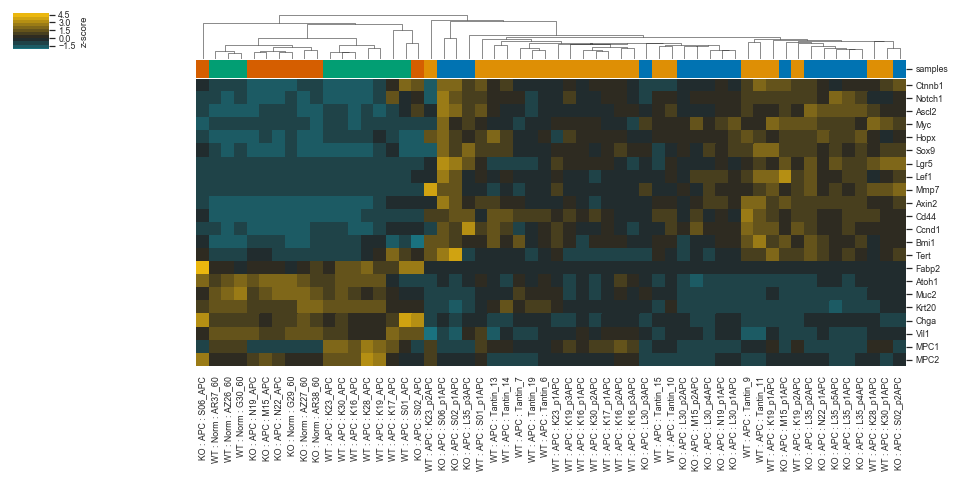

In [31]:
"""
Mouse APC Heatmap Custom22 Probes
"""
xp.heatmap(apc_scaled, apc_info, sample_palette=apc_colors, gene_list=custom22_mouse, 
            figsize=(16,6.5), save_fig=(__path__ + 'plots/APC_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

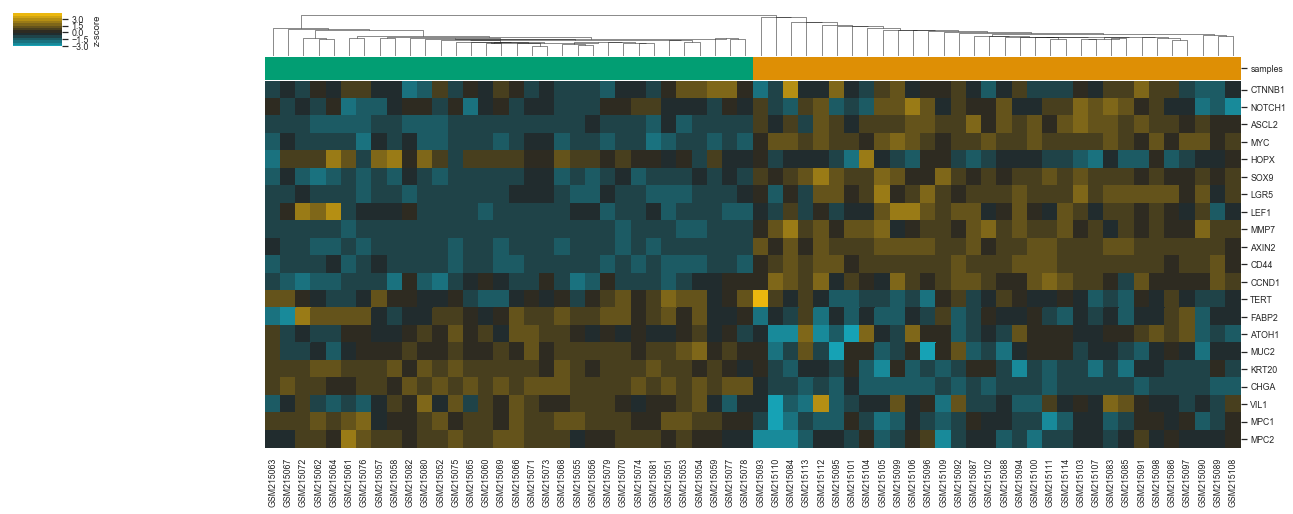

In [32]:
"""
Human GSE8671 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE8671_scaled, info_GSE8671, sample_palette=gse8671_colors, gene_list=custom22_human, 
            figsize=(22,8), save_fig=(__path__ + 'plots/GSE8671_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<Figure size 432x288 with 0 Axes>

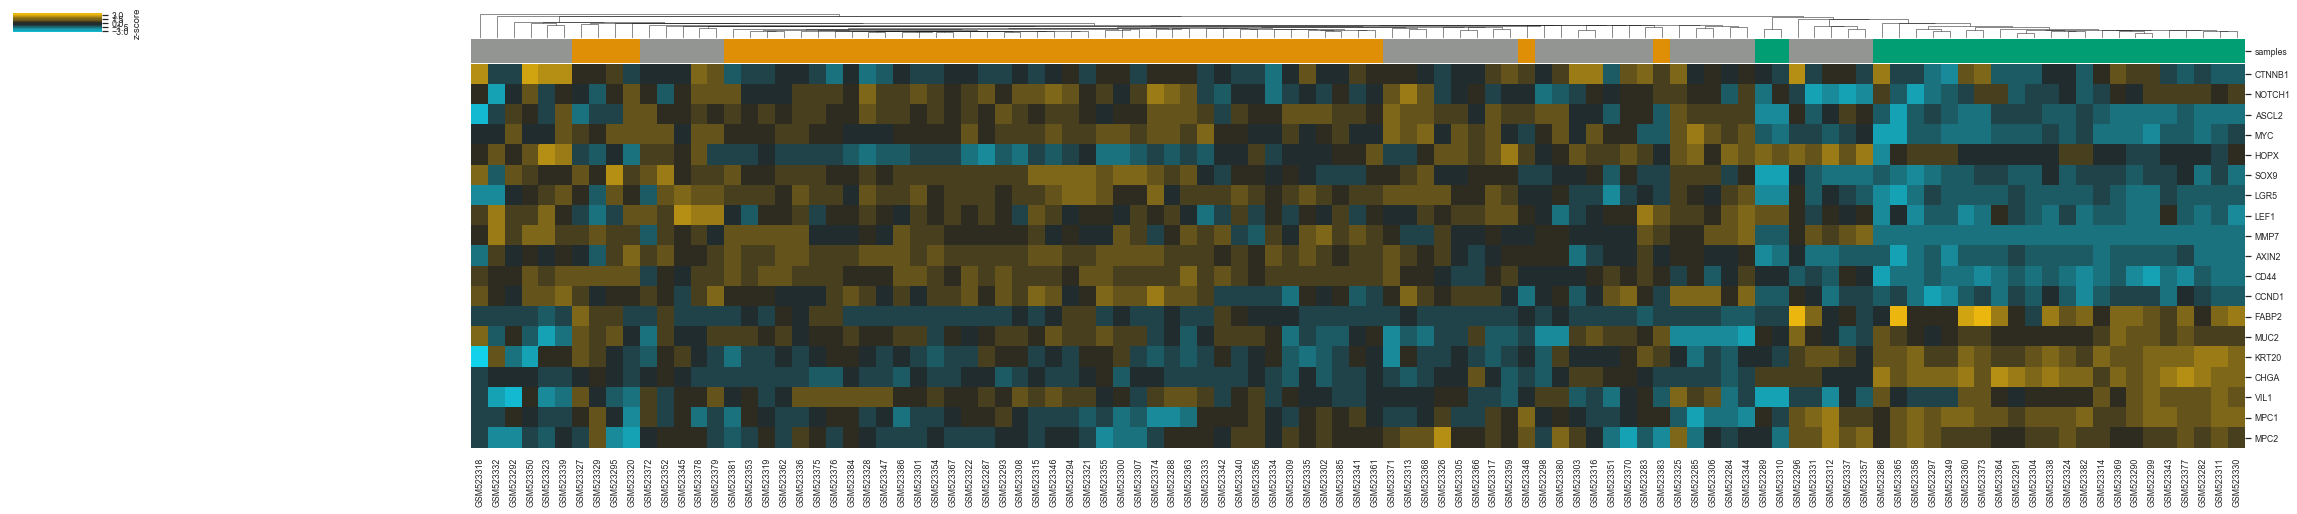

In [33]:
"""
Human GSE20916 Heatmap Custom22 Probes
"""
xp.heatmap(df_GSE20916_scaled, info_GSE20916, sample_palette=gse20916_colors, gene_list=custom22_human, 
            figsize=(40,8), save_fig=(__path__ + 'plots/GSE20916_custom22_heatmap.pdf'), 
            cbar_kws={'label': 'z-score'}, linewidths=0)

<b><u>FIGURE 4 SUPPLEMENT</u></b> 

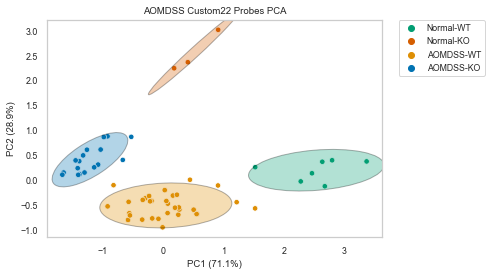

In [34]:
"""
Mouse AOMDSS Heatmap Custom22 Probes -- PCA
"""
xp.pca(aomdss_scaled, aomdss_info, palette=aomdss_colors, order_legend=[3,4,2,1], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/AOMDSS_custom22_PCA_scree.pdf',
       title='AOMDSS Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/AOMDSS_custom22_2CI_PCA.pdf')

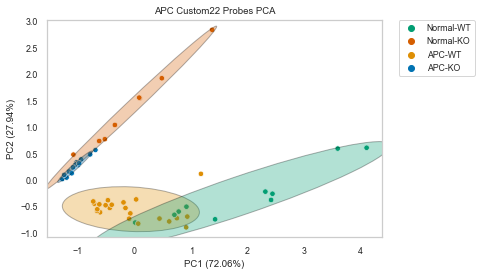

In [35]:
"""
Mouse APC Heatmap Custom22 Probes -- PCA
"""
xp.pca(apc_scaled, apc_info, palette=apc_colors, order_legend=[2,3,1,4], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/APC_custom22_PCA_scree.pdf',
       title='APC Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/APC_custom22_2CI_PCA.pdf')

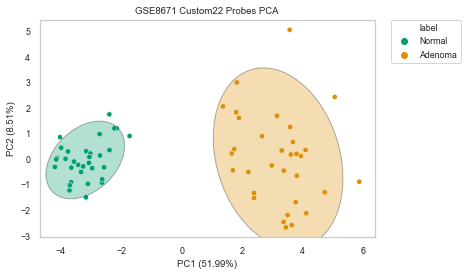

In [36]:
"""
Human GSE8671 Custom22 Probes -- PCA
"""
xp.pca(df_GSE8671_scaled, info_GSE8671, palette=gse8671_colors, n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE8671_custom22_PCA_scree.pdf',
       title='GSE8671 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE8671_custom22_2CI_PCA.pdf')

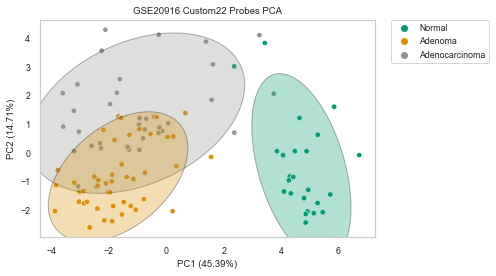

In [37]:
"""
Human GSE20916 Custom22 Probes -- PCA
"""
xp.pca(df_GSE20916_scaled, info_GSE20916, palette=gse20916_colors, order_legend=[1,3,2], n_components=2,
        gene_list=custom22_human, whitegrid=True, grid=False,
       save_scree=__path__ + 'plots/GSE20916_custom22_PCA_scree.pdf',
       title='GSE20916 Custom22 Probes PCA', 
        save_fig=__path__ + 'plots/GSE20916_custom22_2CI_PCA.pdf')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



<Figure size 432x288 with 0 Axes>

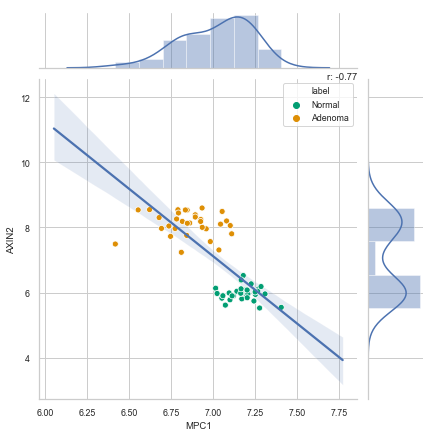

<Figure size 432x288 with 0 Axes>

In [38]:
"""
Human GSE8671 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'AXIN2', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

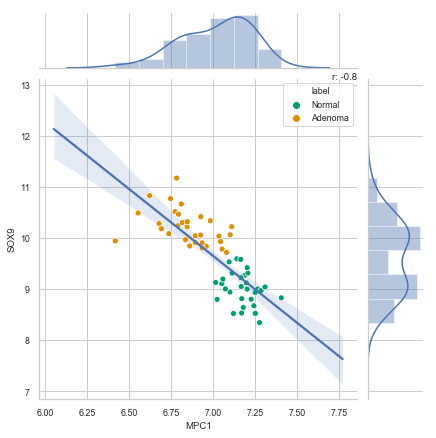

<Figure size 432x288 with 0 Axes>

In [39]:
"""
Human GSE8671 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE8671_collapsed, info_GSE8671, 'MPC1', 'SOX9', palette=gse8671_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE8671_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

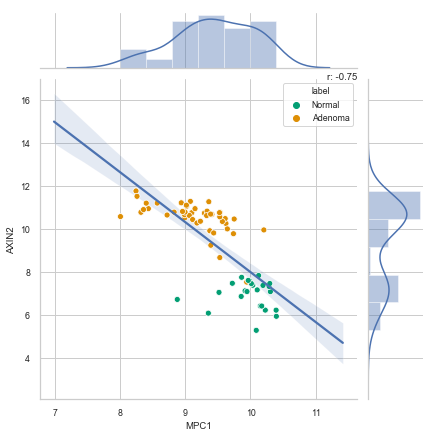

<Figure size 432x288 with 0 Axes>

In [40]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

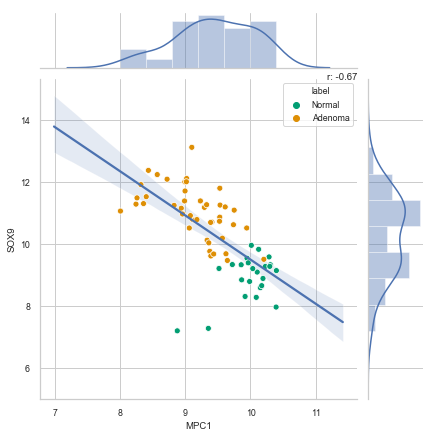

<Figure size 432x288 with 0 Axes>

In [41]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9, no adenocarcinomas
"""
xp.jointplot(df_GSE20916_collapsed_noac, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

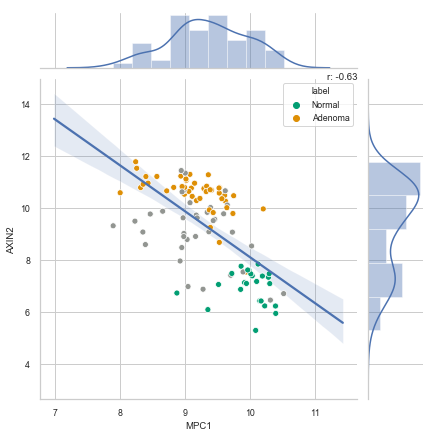

<Figure size 432x288 with 0 Axes>

In [42]:
"""
Human GSE20916 Jointplots -- MPC1 vs AXIN2
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'AXIN2', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_AXIN2_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<Figure size 432x288 with 0 Axes>

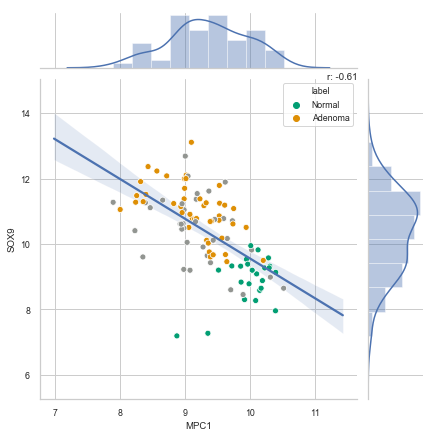

<Figure size 432x288 with 0 Axes>

In [43]:
"""
Human GSE20916 Jointplots -- MPC1 vs SOX9
"""
xp.jointplot(df_GSE20916_collapsed, info_GSE20916, 'MPC1', 'SOX9', palette=gse20916_colors, 
              order=['Normal','Adenoma'],
              save_fig=__path__ + 'plots/GSE20916_MPC1_SOX9_jointplot.pdf', 
              dpi=600, bbox_inches='tight', whitegrid=True, grid=True)

<b><u>FIGURE 4 CORRELATIONS</u></b> 

In [44]:
#GSE20916/MPC1/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC1', __path__ + 'data/GSE20916_MPC1_ALL_correlations.csv')

#GSE20916/MPC2/ALL
xp.linreg(df_GSE20916_collapsed, 'MPC2', __path__ + 'data/GSE20916_MPC2_ALL_correlations.csv')

#GSE20916/MPC1/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC1', __path__ + 'data/GSE20916_MPC1_noAC_correlations.csv')

#GSE20916/MPC2/NoAdenocarcinoma
df_GSE20916_collapsed_noAC = xp.drop_label(df_GSE20916_collapsed, info_GSE20916, 'Adenocarcinoma')
xp.linreg(df_GSE20916_collapsed_noAC, 'MPC2', __path__ + 'data/GSE20916_MPC2_noAC_correlations.csv')

#GSE8671/MPC1/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC1', __path__ + 'data/GSE8671_MPC1_ALL_correlations.csv')

#GSE8671/MPC2/ALL
xp.linreg(df_GSE8671_collapsed, 'MPC2', __path__ + 'data/GSE8671_MPC2_ALL_correlations.csv')